<h1>
The goal of this exercise is to calibrate SiPM's used in the ArGSet setup.
</h1>
<p>
<b> Steps to follow: </b>
<ol>
<li> collect 100 good events: single prominent peak.</li>
<li> Fit the template to all events individually </li>
<li> Take mean of all template parameters found in this manner </li>
<li> </li>
</ol>
</p>

<p>
<b> Current ToDo: </b>
<ul>
<li> Algorithm to select good events.</li>
<li> database of hand picked good events.</li>
<li> Improve fitting. </li>
<li> </li>
</ul>
</p>

<!-- # MIDAS events reconstruction -->

Load packages, setup libraries

In [1]:
# import sys
import numpy as np
from scipy.optimize import curve_fit
# from scipy.stats import chisquare
# from scipy.integrate import simpson
# import matplotlib
import matplotlib.pyplot as plt

from termcolor import colored

# import latexify
# from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter

In [2]:
# import latexify

In [3]:
np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})

In [4]:
%matplotlib ipympl

In [5]:
# from pyreco.manager.manager import Manager

# Pyreco part

Select here midas data, output filename and configuration file

In [6]:
# filename = '/work/sarthak/ArgSet/2024_Mar_27/midas/run00061.mid.lz4'
# outfile = 'jupyR00061'
# confile = 'argset.ini'
# tmin,tmax = 0, 1750

Initialize manager

In [7]:
# cmdline_args = f'--config {confile} -o {outfile} -i {filename}'
# m = Manager( midas=True, cmdline_args=cmdline_args)
# # m = Manager( midas=True) #, cmdline_args=cmdline_args)
# baseline_samples = m.config('reco', 'bl_to', 'int')

Event loop

In [8]:
# #nev_max = m.config('base', 'nevents', 'int')
# nev_max = 2
# for nev, event in enumerate(m.midas): # oddly doing m.midas shifts the 'pointer' to the next event
#     #print(nev, event, event.nchannels)
#     if nev < 2: continue
#     if nev > 1: break
#     print(nev)

In [9]:
# plt.close(1)
# plt.figure(1)
# for nev, event in enumerate(m.midas): # oddly doing m.midas shifts the 'pointer' to the next event
#     #print(nev, event, event.nchannels)
#     # if nev < 2: continue
#     if nev > 0: break
#     # if nev > nev_max: break
#     # if nev > 3: break
#     if event is None: continue
#     if event.nchannels == 0: continue

#     wfs = event.adc_data
#     for i,wf in enumerate(event.adc_data): # over channels
#         wfs[i] = wf-event.adc_baseline[i]
#         plt.plot(wfs[i], label=f'{i}')
#         # plt.plot(wfs[i]/simpson(wfs[i]), label=f'{i}')
        
#     #wfs = m.algos.get_subtracted_waveform(event.adc_data)
#     #wfs = wfs[0:-1,:]
#     #for i,wf in enumerate(wfs[0::3,:]):
#     #    plt.plot(-wf, label=f'{i}')

# plt.xlim(tmin,tmax)
# plt.legend()
# plt.show()

# Numpy part

In [10]:
## we use numpy file from here onwards!
# wfs

In [11]:
wfs_arr = np.load("../finger_plots/midas_wfs_ls.npy", allow_pickle=True) # all preselected events for processing

In [12]:
## we are saving select waveforms
# new_wfs_ls.append(wfs)
# new_wfs_ls = list(new_wfs_ls)
# print(new_wfs_ls)
# len(new_wfs_ls)
# np.save("../finger_plots/midas_wfs_ls.npy", new_wfs_ls, allow_pickle=True)

## data selection

In [13]:
og_wfs = wfs_arr[2].copy() # had success with [3]

In [14]:
n_channel = 2

In [15]:
tmin = 0
tmax = min(og_wfs[n_channel].shape[0], 1750)

## rescaling

In [16]:
## this approach is not going to be used.
# # dividng by area under the curve so that new area under the curve = 1
# for _c in range(3):
#     wfs[_c] = np.divide( wfs[_c], simpson(wfs[_c] ) )

In [17]:
# temp
# simpson(wfs[2])

In [18]:
# temp
# 0.0010*simpson(wfs[2])

In [19]:
### shifting
def transform_shift_wfs(og_wfs:np.ndarray) -> tuple:
    wfs = np.copy(og_wfs)
    shift_values = {}
    for _c in range(3):
        a = np.min(og_wfs[_c])
        if a < 0:
            print(f"channel {_c} below {0}: value of min element = {a}.")
            wfs[_c] = og_wfs[_c] + np.abs(a)
            shift_values[str(_c)] = a
        else:
            shift_values[str(_c)] = 0
    return (wfs, shift_values)

In [20]:
wfs, shift_values = transform_shift_wfs(og_wfs)
# wfs[2]

channel 0 below 0: value of min element = -50.0.
channel 1 below 0: value of min element = -15.0.
channel 2 below 0: value of min element = -18.0.


In [21]:
shift_values

{'0': -50.0, '1': -15.0, '2': -18.0}

## Plotting npy data

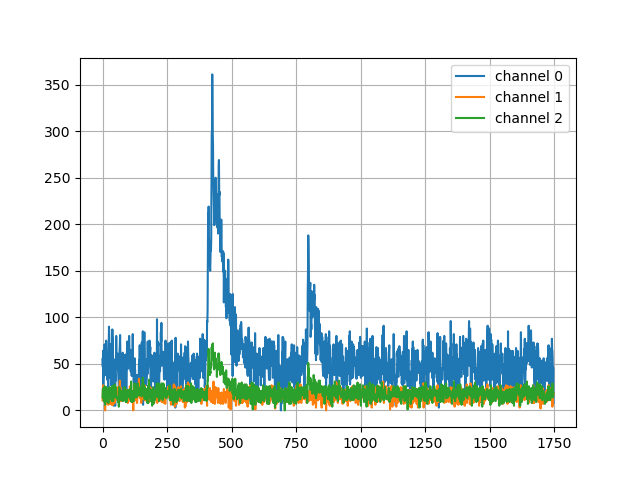

In [22]:
plt.close(2)
plt.figure(2)
plt.title('transformed data')
for _c in range(3):
    plt.plot(wfs[_c], label=f'channel {_c}')

plt.legend()

plt.grid()

## Template function

In [23]:
# template as original given passed by Marcin
# def simplesum(t, t0, sigma, tau, scale):
#     return (1-scale)/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-t0)/(sigma))**2/2) + scale*np.heaviside(t-t0,1)/tau*np.exp(-(t-t0)/tau)

# @latexify.function
def simplesum(t, t0, sigma, tau, scale, baseline, K):
    return baseline + K*((1-scale)/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-t0)/(sigma))**2/2) + scale*np.heaviside(t-t0,0)/tau*np.exp(-(t-t0)/tau))

In [24]:
# @latexify.function()
# simplesum

## Fit range

In [25]:
# fit_begin = 400
# fit_end = 600
# fit_begin = 325 # 400 #350
# fit_end = 775 # 600 # THIS gives best result # 650  # this must be optimal
fit_begin = 0
fit_end = wfs[2].shape[0] -1 
x_values = np.arange(tmin, tmax+1)
# x_values = np.arange(tmin, tmax)

## Fitter

### Mean of Squared Error

In [26]:
mse_700_800 = np.std(wfs[2][700:800])/np.sqrt(wfs[2][700:800].shape[0])

In [27]:
## use rmse_700_800 into the curve_fit

In [28]:
p0_input = [440.0,   2.5,  80.0,   0.95, 0.0, 10000.0] #t0=416, sigma=1.85, tau=87, scale=0.98, baseline=0.0002, K=12560

fittedparameters, pcov = curve_fit(simplesum, x_values[fit_begin:fit_end+1], wfs[2][fit_begin:fit_end+1], \
                                    p0 = p0_input, \
                                    sigma=mse_700_800*np.ones(wfs[2].shape), \
                                    bounds = ([0, 0, 0, 0, -np.inf, 0], \
                                              [np.inf, 10, np.inf, 1, np.inf, np.inf])
                                    )

In [29]:
fittedparameters

array([       416,      9.775,      68.19,     0.8104,      17.98,
             3194])

In [30]:
# pcov

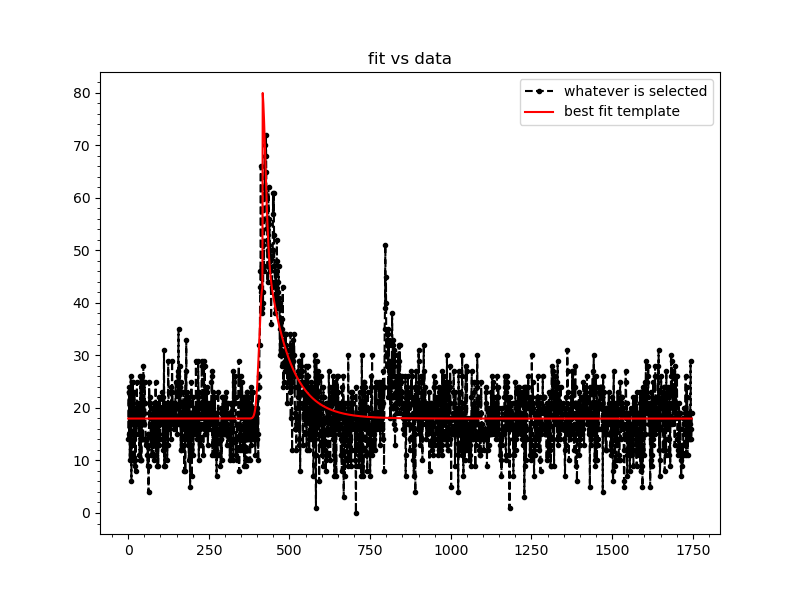

In [31]:
x_values = x_values[:wfs[1].shape[0]]

plt.close(3)
plt.figure(3, figsize=(8,6))
plt.title('fit vs data')
plt.plot(x_values, wfs[2], '.--', color='black', alpha=1.0, label='whatever is selected')
# plt.plot(x_values[fit_begin:fit_end+1], wfs[2][fit_begin:fit_end+1], '.--', color='C2', alpha=0.1, label='whatever is selected')
# plt.plot(x_values[fit_begin:fit_end+1], wfs[2][fit_begin:fit_end+1]/auc, '.--', color='C2', alpha=0.1, label='whatever is selected')
plt.plot(x_values[fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], *fittedparameters), \
        '-', color='red', alpha=1.0, label='best fit template');

# plt.plot(x_values[fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], t0=400, sigma=10, tau=10, scale=0.9), \
#          '.-', color='purple', label='neat');

# plt.xlim(300, 800)
# plt.xticks()
plt.legend()
plt.minorticks_on()
ax = plt.gca()
# ax.set_xticks(x_values[:50:], minor=True)
## ax.xaxis.set_minor_locator(plt.MaxNLocator(5))
# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%i"))
# ax.tick_params(axis="x", which="both", rotation=90)
# plt.xlim(200, 1000)
plt.show()

### Chi-Square

In [35]:
### As usual, scipy.stat chisquare doesn't work for me.
# chisquare(wfs[2][fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], *fittedparameters))

In [36]:
def red_chisq(f_obs, f_exp, fittedparameters):
    # chisqr = np.sum((f_obs - f_exp)**2 / f_exp)
    chisqr = np.sum((f_obs - f_exp)**2 / np.abs(f_exp)) # changed
    ndf = f_obs.shape[0]
    return chisqr/(ndf -fittedparameters.shape[0])

In [37]:
print( colored('Reducded Chisquare:', 'red', attrs = ['blink', 'bold']) )
print( colored(red_chisq(wfs[2][fit_begin:fit_end+1], \
            simplesum(x_values[fit_begin:fit_end+1], *fittedparameters), \
            fittedparameters 
          )
, 'cyan', attrs= ['bold'])
)

Reducded Chisquare:
1.760029554659216


### Getting back actual parameters

In [38]:
# def reverse_transform_wfs(wfs:np.ndarray, shift_values:dict)->None:
#     for _c in shift_values:
#         wfs[_c] = wfs[_c] + shift_values[_c]


def transform_param(fittedparameters:np.ndarray, shift_values:dict, n_channel:int)->np.ndarray:
    fittedparameters[4] = fittedparameters[4] + shift_values[str(n_channel)]
    
    return fittedparameters

In [39]:
fittedparameters_transformed  = transform_param(fittedparameters, shift_values, n_channel)

In [40]:
fittedparameters_transformed

array([       416,      9.775,      68.19,     0.8104,   -0.02265,
             3194])

In [41]:
### Getting back actual parameters

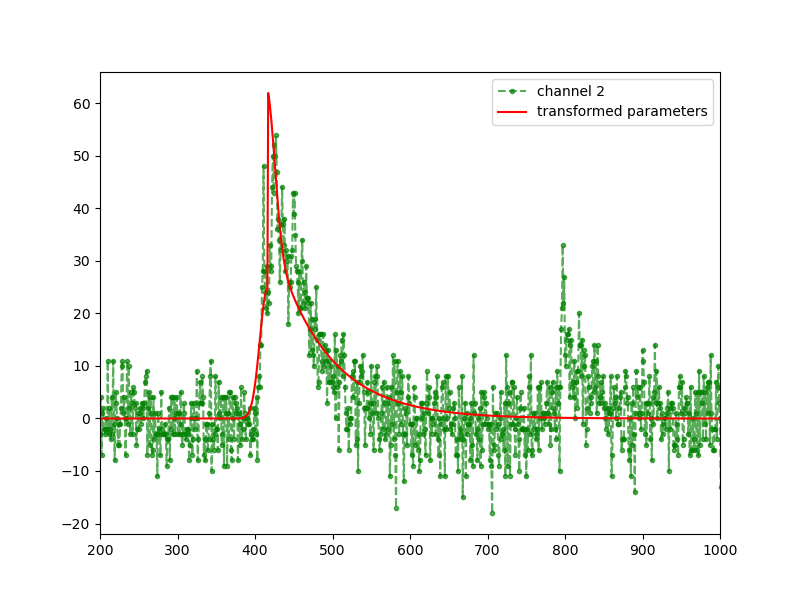

In [46]:
plt.title('best fit overlayed on untransformed data')
plt.close(4)
plt.figure(4, figsize=(8,6))
plt.plot(x_values, og_wfs[2], '.--', color='green', alpha=0.65, label=f'channel {n_channel}')
# plt.plot(x_values[fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], t0=416, sigma=2.5, tau=84, scale=0.97), \
#          '+', color='purple', label='neat');
plt.plot(x_values[fit_begin:fit_end+1], \
                    simplesum(x_values[fit_begin:fit_end+1], *fittedparameters_transformed), \
                                                    # simplesum(x_values[fit_begin:fit_end+1],                     
                                                #   t0=416, sigma=1.85, tau=100, scale=0.98, 
                                                #   baseline_pre=0.0013, 
                                                #   baseline_post = 0.000005, 
                                                #   K=12560), \
         '-', color='red',alpha=1.0, label='transformed parameters');

plt.xlim(200, 1000)
plt.legend()
# plt.show()

# Not Used

In [ ]:
# sys.exit()

Filtering with ARMA

In [ ]:
# plt.close(2)
# plt.figure(2)
# from pyreco.reco.filtering import WFFilter
# mfilter = WFFilter(m.config)
# flt = np.reshape(mfilter.numba_fast_filter(wfs),newshape=wfs.shape)
# for i,wf in enumerate(flt):
#         plt.plot(wf, label=f'{i}')

# plt.xlim(tmin,tmax)
# # plt.show()

Running average filter

In [ ]:
# plt.close(3)
# plt.figure(3)
# mas = m.algos.running_mean(flt,gate=60)
# flt = flt - mas 
# flt = np.where(flt>0,flt, 0)
# for i,wf in enumerate(flt):
#     rms = m.algos.get_rms(wf)    
#     plt.plot(np.where(wf > 3*rms, wf, 0), label=f'{i}')

# plt.xlim(tmin,tmax)
# plt.show()